# Importação da base


In [2]:
# Importar as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

# Carregamento da base

In [3]:
# Subir o arquivo no Colab e carregar a base de dados
from google.colab import files
uploaded = files.upload()

# Carregar o arquivo que você subiu (substitua pelo nome correto)
df = pd.read_csv("drug200.csv")

# Exibir as primeiras linhas da base de dados
df.head()

Saving drug200.csv to drug200.csv


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


# Pré-processamento dos dados

In [4]:
# Separar X e y (coluna 'Drug' é a variável resposta)
X = df.drop('Drug', axis=1) # exclui só a variável Drug
y = df['Drug']

# Verificar quais colunas são categóricas
print(X.dtypes)

# Converter variáveis categóricas em variáveis dummy (0 e 1)
X = pd.get_dummies(X, drop_first=True)

# DESBALANCEADO com proporção de igual do conjunto de dados original
# Dividir os dados em treino e teste
  # test_size=0.3 : 30% dos dados serão usados para teste, enquanto 70% serão usados para treinar os
  # random_state=42 : seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# BALANCEADO
# Aplicar SMOTE ao conjunto de treino
smote = SMOTE(random_state=42) # seed para mesma geração de amostras sintéticas
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
# fit_resample faz o oversamplig apenas na classe minoritária

# Padronizar os dados (opcional para alguns métodos)
scaler = StandardScaler() # média zero e desvio padrão 1
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_balanced = scaler.transform(X_train_balanced)  # Conjunto balanceado com SMOTE

# Selecionar apenas colunas categóricas
categorical_columns = df.select_dtypes(include=['object', 'category'])

# Aplicar value_counts() a cada coluna categórica
for col in categorical_columns:
    print(f"Contagem de valores para a coluna {col}:")
    print(df[col].value_counts())
    print("\n")

# Exibir a contagem de valores para y_train e y_test
print("\nContagem de valores para y_train:")
print(y_train.value_counts())
print("\nContagem de valores para y_test:")
print(y_test.value_counts())

print("\nVariáveirs dummy:")
print(X.head())

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
dtype: object
Contagem de valores para a coluna Sex:
Sex
M    104
F     96
Name: count, dtype: int64


Contagem de valores para a coluna BP:
BP
HIGH      77
LOW       64
NORMAL    59
Name: count, dtype: int64


Contagem de valores para a coluna Cholesterol:
Cholesterol
HIGH      103
NORMAL     97
Name: count, dtype: int64


Contagem de valores para a coluna Drug:
Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64



Contagem de valores para y_train:
Drug
DrugY    64
drugX    38
drugA    16
drugC    11
drugB    11
Name: count, dtype: int64

Contagem de valores para y_test:
Drug
DrugY    27
drugX    16
drugA     7
drugC     5
drugB     5
Name: count, dtype: int64

Variáveirs dummy:
   Age  Na_to_K  Sex_M  BP_LOW  BP_NORMAL  Cholesterol_NORMAL
0   23   25.355  False   False      False               False
1   47   13.093   True    True  

In [ ]:
# Proporção das classes na base original
print("\nProporção das classes na base original:")
print(y.value_counts(normalize=True))

# Proporção das classes no conjunto de treino
print("\nProporção das classes no conjunto de treino:")
print(y_train.value_counts(normalize=True))

# Proporção das classes no conjunto de teste
print("\nProporção das classes no conjunto de teste:")
print(y_test.value_counts(normalize=True))

# Comparação das proporções
print("\nProporção original no conjunto de treino:")
print(y_train.value_counts(normalize=True))

print("\nProporção balanceada no conjunto de treino (após SMOTE):")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

# Comparação das quantidades
print("\nQuantidade original no conjunto de treino:")
print(y_train.value_counts())

print("\nQuantidade balanceada no conjunto de treino (após SMOTE):")
print(pd.Series(y_train_balanced).value_counts())



Proporção das classes na base original:
Drug
DrugY    0.455
drugX    0.270
drugA    0.115
drugC    0.080
drugB    0.080
Name: proportion, dtype: float64

Proporção das classes no conjunto de treino:
Drug
DrugY    0.457143
drugX    0.271429
drugA    0.114286
drugC    0.078571
drugB    0.078571
Name: proportion, dtype: float64

Proporção das classes no conjunto de teste:
Drug
DrugY    0.450000
drugX    0.266667
drugA    0.116667
drugC    0.083333
drugB    0.083333
Name: proportion, dtype: float64

Proporção original no conjunto de treino:
Drug
DrugY    0.457143
drugX    0.271429
drugA    0.114286
drugC    0.078571
drugB    0.078571
Name: proportion, dtype: float64

Proporção balanceada no conjunto de treino (após SMOTE):
Drug
DrugY    0.2
drugX    0.2
drugC    0.2
drugA    0.2
drugB    0.2
Name: proportion, dtype: float64

Quantidade original no conjunto de treino:
Drug
DrugY    64
drugX    38
drugA    16
drugC    11
drugB    11
Name: count, dtype: int64

Quantidade balanceada no conjun

# 1. Regresão Logística

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_with_best_threshold_multiclass(model, X_train, X_test, y_train, y_test, model_name):
    # Treinar o modelo
    model.fit(X_train, y_train)

    # Prever as probabilidades
    y_prob = model.predict_proba(X_test)
    classes = model.classes_

    # Encontrar o melhor ponto de corte para cada classe
    thresholds = {}
    best_f1_scores = {}
    y_preds = {}

    for idx, cls in enumerate(classes):
        best_f1 = 0
        best_threshold = None
        best_pred = None

        for threshold in np.arange(0.1, 1.0, 0.01):
            # Classificar como 'pertence à classe' se probabilidade >= threshold
            y_pred = (y_prob[:, idx] >= threshold).astype(int)
            y_true_binary = (y_test == cls).astype(int)  # Transformar rótulos em binário para a classe atual

            # Calcular F1-Score
            f1 = f1_score(y_true_binary, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                best_pred = y_pred

        # Salvar os melhores valores
        thresholds[cls] = best_threshold
        best_f1_scores[cls] = best_f1
        y_preds[cls] = best_pred

    # Gerar predições finais com os melhores thresholds
    y_pred_final = np.array([
        classes[np.argmax([y_prob[i, idx] >= thresholds[cls] for idx, cls in enumerate(classes)])]
        for i in range(len(y_test))
    ])

    # Calcular métricas gerais
    accuracy = accuracy_score(y_test, y_pred_final)
    recall = recall_score(y_test, y_pred_final, average='macro')
    precision = precision_score(y_test, y_pred_final, average='macro')
    f1 = f1_score(y_test, y_pred_final, average='macro')

    # Exibir os melhores thresholds por classe
    print(f"Melhores pontos de corte por classe: {thresholds}")

    # Exibir as métricas gerais
    print(f"{model_name} - Acurácia: {accuracy:.7f}")
    print(f"{model_name} - Precisão: {precision:.7f}")
    print(f"{model_name} - Revocação: {recall:.7f}")
    print(f"{model_name} - F1-Score: {f1:.7f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_final, target_names=classes))

    # Matriz de Confusão
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, display_labels=classes, cmap='Blues')
    plt.title(f"{model_name} - Matriz de Confusão")
    plt.show()


Melhores pontos de corte por classe: {'DrugY': 0.3699999999999999, 'drugA': 0.3199999999999999, 'drugB': 0.4999999999999998, 'drugC': 0.21999999999999995, 'drugX': 0.29999999999999993}
Regressão Logística (Balanceado) - Acurácia: 0.9333333
Regressão Logística (Balanceado) - Precisão: 0.9629630
Regressão Logística (Balanceado) - Revocação: 0.9051852
Regressão Logística (Balanceado) - F1-Score: 0.9234205

Classification Report:
              precision    recall  f1-score   support

       DrugY       0.93      0.93      0.93        27
       drugA       1.00      1.00      1.00         7
       drugB       1.00      0.60      0.75         5
       drugC       1.00      1.00      1.00         5
       drugX       0.89      1.00      0.94        16

    accuracy                           0.93        60
   macro avg       0.96      0.91      0.92        60
weighted avg       0.94      0.93      0.93        60



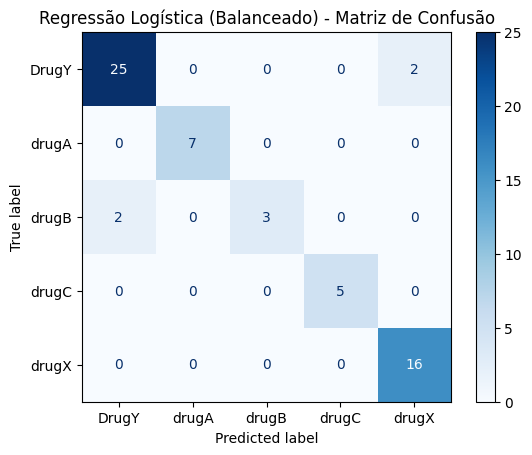

In [ ]:
# Regressão Logística
log_reg = LogisticRegression()
evaluate_model_with_best_threshold_multiclass(log_reg, X_train_balanced, X_test, y_train_balanced, y_test, "Regressão Logística (Balanceado)")


Melhores pontos de corte por classe: {'DrugY': 0.44999999999999984, 'drugA': 0.2799999999999999, 'drugB': 0.3599999999999999, 'drugC': 0.13999999999999999, 'drugX': 0.30999999999999994}
Regressão Logística (Desbalanceado) - Acurácia: 0.9333333
Regressão Logística (Desbalanceado) - Precisão: 0.9629630
Regressão Logística (Desbalanceado) - Revocação: 0.9051852
Regressão Logística (Desbalanceado) - F1-Score: 0.9234205

Classification Report:
              precision    recall  f1-score   support

       DrugY       0.93      0.93      0.93        27
       drugA       1.00      1.00      1.00         7
       drugB       1.00      0.60      0.75         5
       drugC       1.00      1.00      1.00         5
       drugX       0.89      1.00      0.94        16

    accuracy                           0.93        60
   macro avg       0.96      0.91      0.92        60
weighted avg       0.94      0.93      0.93        60



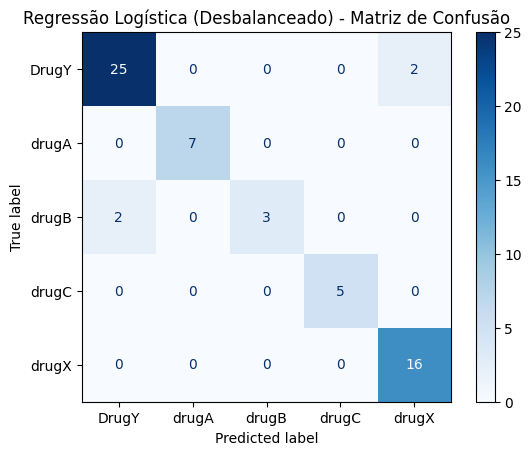

In [ ]:
# Regressão Logística com Dados Desbalanceados
log_reg = LogisticRegression()
evaluate_model_with_best_threshold_multiclass(log_reg, X_train, X_test, y_train, y_test, "Regressão Logística (Desbalanceado)")


# 2. Árvore de Decisão

DESBALANCEADOS

In [ ]:
# DESBALNACEADO - testa diferentes hiperparametros
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Tabela para armazenar os resultados para dados desbalanceados
results_dt = []

# Valores a serem testados para max_depth, min_samples_split, min_samples_leaf
max_depth_values = [5, 10, 15, 20, None]  # Testar com profundidades diferentes e sem limite
min_samples_split_values = [2, 10, 20]
min_samples_leaf_values = [1, 5, 10]

# Testar os critérios de divisão 'gini' e 'entropy'
criteria = ['gini', 'entropy']

for criterion in criteria:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            for min_samples_leaf in min_samples_leaf_values:
                # Treinar o modelo com os parâmetros especificados
                dt = DecisionTreeClassifier(
                    criterion=criterion,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )

                dt.fit(X_train, y_train)
                y_pred = dt.predict(X_test)

                # Cálculo das métricas
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='macro')
                recall = recall_score(y_test, y_pred, average='macro')
                f1 = f1_score(y_test, y_pred, average='macro')

                # Armazenar os resultados
                results_dt.append({
                    'criterion': criterion,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1
                })

Métricas para Árvore de Decisão com critério 'gini' e parâmetros padrão:
Acurácia: 0.9833
Precisão: 0.9929
Recall: 0.9875
F1-Score: 0.9899


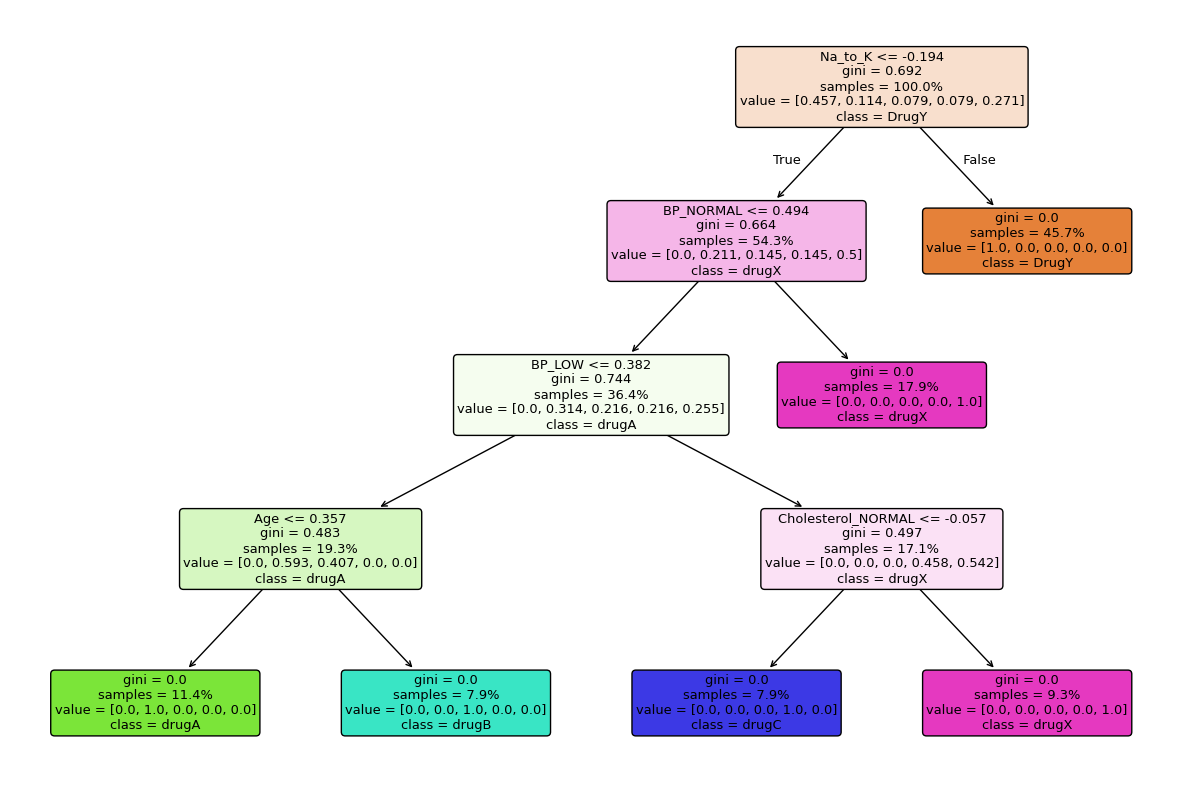

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# Converta X_train e X_test para DataFrames, caso ainda estejam como ndarrays
X_train_df = pd.DataFrame(X_train, columns=X.columns)  # Substitua X.columns pelos nomes das colunas do seu dataset
X_test_df = pd.DataFrame(X_test, columns=X_train_df.columns)

# Treinar o modelo usando o critério 'gini' e os valores padrão para outros hiperparâmetros
dt = DecisionTreeClassifier(criterion='gini', random_state=42)
dt.fit(X_train_df, y_train)

# Fazer previsões no conjunto de teste
y_pred = dt.predict(X_test_df)

# Cálculo das métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Imprimir as métricas
print("Métricas para Árvore de Decisão com critério 'gini' e parâmetros padrão:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualizar a árvore de decisão
plt.figure(figsize=(15, 10))
plot_tree(
    dt,
    filled=True,
    feature_names=X_train_df.columns,  # Corrigido para usar as colunas do DataFrame
    class_names=[str(cls) for cls in dt.classes_],  # Convertendo classes para strings
    rounded=True,
    proportion=True  # Mostra porcentagens ao invés de contagens
)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


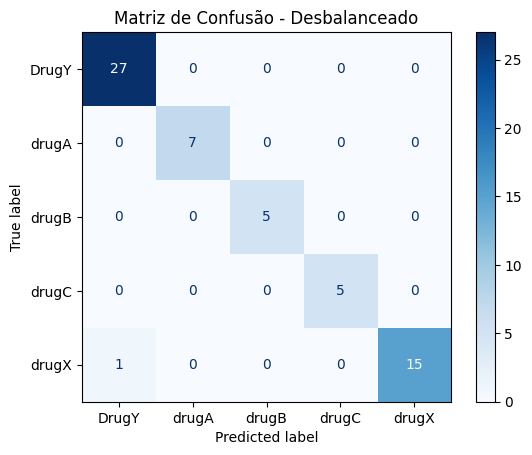

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Exibir a matriz de confusão
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap="Blues")
plt.title("Matriz de Confusão - Desbalanceado")
plt.show()

BALANCEADOS

Métricas para o conjunto balanceado com critério 'gini' e parâmetros padrão:
Acurácia: 0.9833
Precisão: 0.9929
Recall: 0.9875
F1-Score: 0.9899


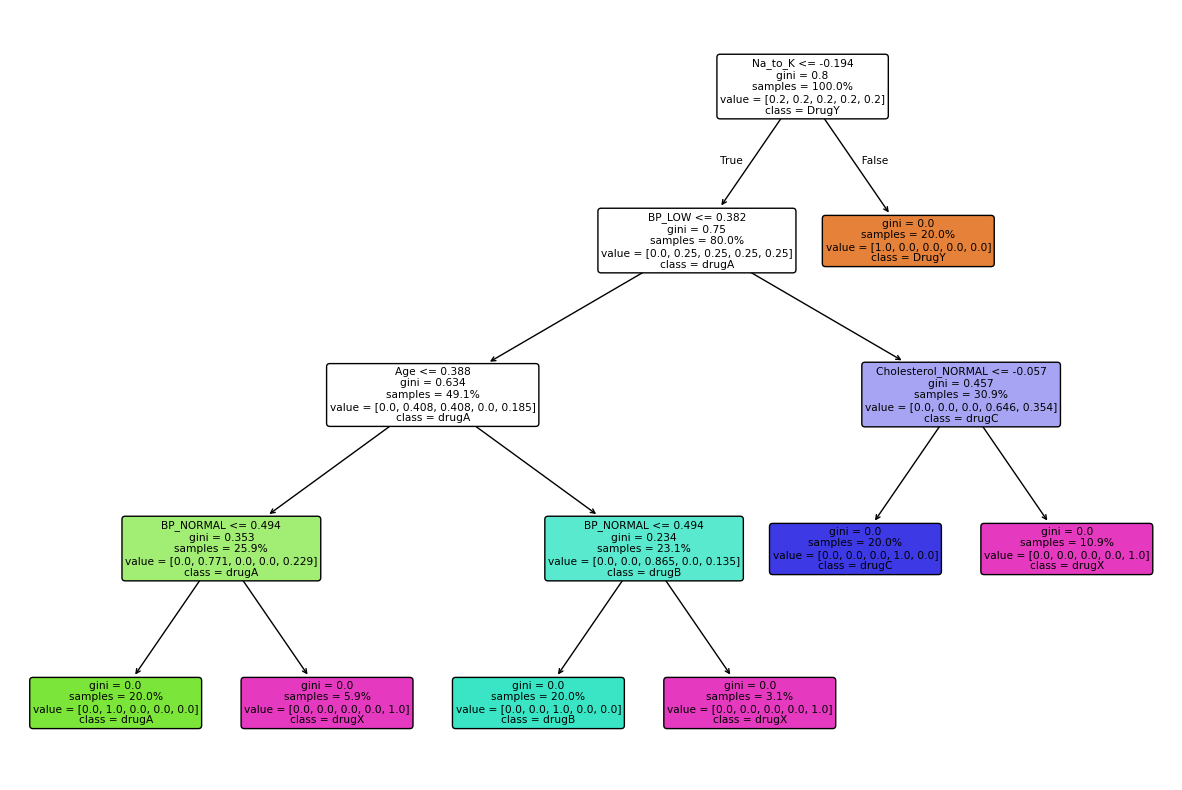

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Instanciar o classificador de árvore de decisão com critério 'gini' e parâmetros padrão
dt_balanced = DecisionTreeClassifier(criterion='gini', random_state=42)

# Treinar o modelo no conjunto de dados balanceado
dt_balanced.fit(X_train_balanced, y_train_balanced)

# Fazer previsões no conjunto de teste
y_pred_balanced = dt_balanced.predict(X_test)

# Calcular métricas de avaliação
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
precision_balanced = precision_score(y_test, y_pred_balanced, average='macro')
recall_balanced = recall_score(y_test, y_pred_balanced, average='macro')
f1_balanced = f1_score(y_test, y_pred_balanced, average='macro')

# Imprimir métricas
print("Métricas para o conjunto balanceado com critério 'gini' e parâmetros padrão:")
print(f"Acurácia: {accuracy_balanced:.4f}")
print(f"Precisão: {precision_balanced:.4f}")
print(f"Recall: {recall_balanced:.4f}")
print(f"F1-Score: {f1_balanced:.4f}")

# Visualizar a árvore de decisão com porcentagens
plt.figure(figsize=(15, 10))
plot_tree(
    dt_balanced,
    filled=True,
    feature_names=X.columns,  # Corrigido para usar as colunas do DataFrame
    class_names=[str(cls) for cls in dt.classes_],  # Convertendo classes para strings
    rounded=True,
    proportion=True  # Mostra porcentagens ao invés de contagens
)
plt.show()



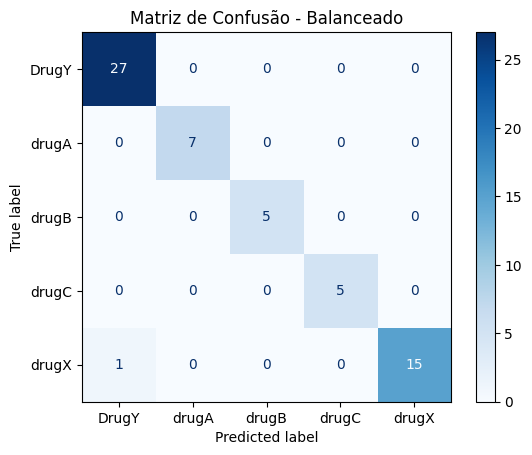

In [ ]:
# Exibir a matriz de confusão
ConfusionMatrixDisplay.from_estimator(dt_balanced, X_test, y_test, cmap="Blues")
plt.title("Matriz de Confusão - Balanceado")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


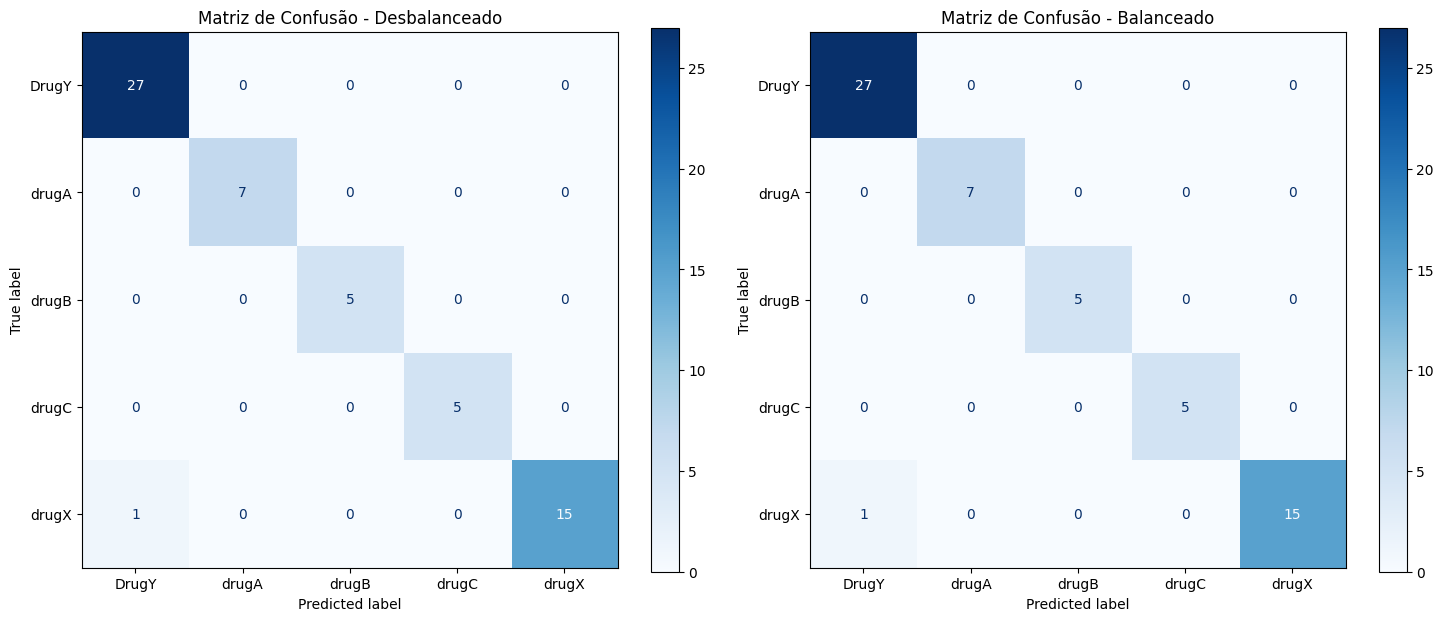

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matrizes de confusão para os modelos desbalanceado e balanceado
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matrizes de Confusão para o modelo desbalanceado
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusão - Desbalanceado")

# Matrizes de Confusão para o modelo balanceado
ConfusionMatrixDisplay.from_estimator(dt_balanced, X_test, y_test, cmap="Blues", ax=axes[1])
axes[1].set_title("Matriz de Confusão - Balanceado")

plt.tight_layout()
plt.show()


O que as Matrizes de Confusão mostram?
A matriz de confusão fornece uma visão detalhada sobre os erros e acertos do modelo, mostrando:

Verdadeiros positivos (TP): Predições corretas da classe positiva.
Falsos positivos (FP): Predições erradas da classe positiva.
Verdadeiros negativos (TN): Predições corretas da classe negativa.
Falsos negativos (FN): Predições erradas da classe negativa.
Com isso, você pode observar como o modelo está lidando com as diferentes classes e se há mais falsos positivos ou falsos negativos, além de comparar com as métricas de desempenho.

In [ ]:
print("Resultados para o modelo Desbalanceado:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nResultados para o modelo Balanceado:")
print(f"Acurácia: {accuracy_balanced:.4f}")
print(f"Precisão: {precision_balanced:.4f}")
print(f"Recall: {recall_balanced:.4f}")
print(f"F1-score: {f1_balanced:.4f}")


Resultados para o modelo Desbalanceado:
Acurácia: 0.9833
Precisão: 0.9929
Recall: 0.9875
F1-score: 0.9899

Resultados para o modelo Balanceado:
Acurácia: 0.9833
Precisão: 0.9929
Recall: 0.9875
F1-score: 0.9899


# 3. Random Forest

DESBALANCEADOS

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Defina os valores dos hiperparâmetros que você quer testar
max_features_values = [1, 2, 3, 7]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 10]

# Tabela para armazenar os resultados para dados desbalanceados
results_rf = []

# Loop para testar os diferentes parâmetros
for max_features in max_features_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            # Criar o modelo RandomForest com os parâmetros selecionados
            rf = RandomForestClassifier(
                max_features=max_features,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )

            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)

            # Calcular as métricas
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')

            # Armazenar os resultados
            results_rf.append({
                'max_features': max_features,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })

# Converter para DataFrame para análise
df_results_rf = pd.DataFrame(results_rf)

# Exibir os resultados
print("Resultados para o conjunto desbalanceado:")
print(df_results_rf)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Resultados para o conjunto desbalanceado:
    max_features  min_samples_split  min_samples_leaf  accuracy  precision  \
0              1                  2                 1  0.983333   0.992857   
1              1                  2                 2  0.983333   0.992857   
2              1                  2                10  0.766667   0.694071   
3              1                  5                 1  0.983333   0.992857   
4              1                  5                 2  0.983333   0.992857   
5              1                  5                10  0.766667   0.694071   
6              1                 10                 1  0.983333   0.992857   
7              1                 10                 2  0.983333   0.992857   
8              1                 10                10  0.766667   0.694071   
9              2                  2                 1  0.983333   0.992857   
10             2                  2                 2  0.983333   0.992857   
11             2      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Acurácia (Desbalanceado): 0.9833
Precisão (Desbalanceado): 0.9929
Recall (Desbalanceado): 0.9875
F1-Score (Desbalanceado): 0.9899


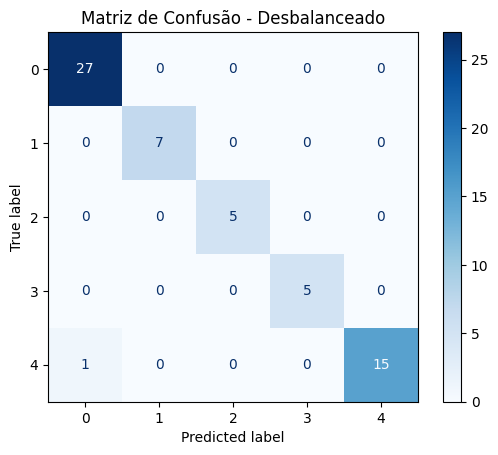

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Defina um valor fixo para os hiperparâmetros
max_features = 'sqrt'  # Escolha entre 1, 5, 10, 'sqrt', 'log2'
min_samples_split = 5  # Escolha entre 2, 5, 10
min_samples_leaf = 2   # Escolha entre 1, 2, 5

# Criar o modelo RandomForest com os parâmetros selecionados
rf = RandomForestClassifier(
    max_features=max_features,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

# Treinamento com dados desbalanceados
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calcular as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Exibir as métricas
print(f"Acurácia (Desbalanceado): {accuracy:.4f}")
print(f"Precisão (Desbalanceado): {precision:.4f}")
print(f"Recall (Desbalanceado): {recall:.4f}")
print(f"F1-Score (Desbalanceado): {f1:.4f}")

# Visualizar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Desbalanceado")
plt.show()


BALANCEADOS

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Defina os valores dos hiperparâmetros que você quer testar
max_features_values = [1, 2, 3, 7]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 10]

# Tabela para armazenar os resultados para dados balanceados
results_rf_balanced = []

# Loop para testar os diferentes parâmetros
for max_features in max_features_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            # Criar o modelo RandomForest com os parâmetros selecionados
            rf_balanced = RandomForestClassifier(
                max_features=max_features,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )

            rf_balanced.fit(X_train_balanced, y_train_balanced)
            y_pred_balanced = rf_balanced.predict(X_test)

            # Calcular as métricas
            accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
            precision_balanced = precision_score(y_test, y_pred_balanced, average='macro')
            recall_balanced = recall_score(y_test, y_pred_balanced, average='macro')
            f1_balanced = f1_score(y_test, y_pred_balanced, average='macro')

            # Armazenar os resultados
            results_rf_balanced.append({
                'max_features': max_features,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'accuracy': accuracy_balanced,
                'precision': precision_balanced,
                'recall': recall_balanced,
                'f1_score': f1_balanced
            })

# Converter para DataFrame para análise
df_results_rf_balanced = pd.DataFrame(results_rf_balanced)

# Exibir os resultados
print("Resultados para o conjunto balanceado:")
print(df_results_rf_balanced)


Resultados para o conjunto balanceado:
    max_features  min_samples_split  min_samples_leaf  accuracy  precision  \
0              1                  2                 1  1.000000   1.000000   
1              1                  2                 2  0.983333   0.992857   
2              1                  2                10  0.983333   0.992857   
3              1                  5                 1  1.000000   1.000000   
4              1                  5                 2  0.983333   0.992857   
5              1                  5                10  0.983333   0.992857   
6              1                 10                 1  0.983333   0.992857   
7              1                 10                 2  0.983333   0.992857   
8              1                 10                10  0.983333   0.992857   
9              2                  2                 1  0.983333   0.992857   
10             2                  2                 2  0.983333   0.992857   
11             2         

Acurácia (Balanceado): 0.9833
Precisão (Balanceado): 0.9929
Recall (Balanceado): 0.9875
F1-Score (Balanceado): 0.9899


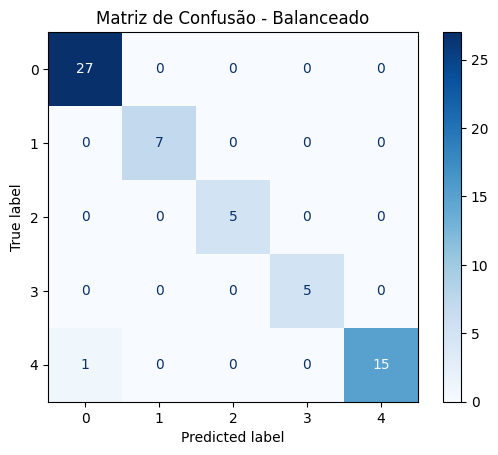

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Defina um valor fixo para os hiperparâmetros
max_features = 'sqrt'  # Escolha entre 1, 5, 10, 'sqrt', 'log2'
min_samples_split = 5  # Escolha entre 2, 5, 10
min_samples_leaf = 2   # Escolha entre 1, 2, 5

# Criar o modelo RandomForest com os parâmetros selecionados
rf_balanced = RandomForestClassifier(
    max_features=max_features,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

# Treinamento com dados balanceados
rf_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = rf_balanced.predict(X_test)

# Calcular as métricas
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
precision_balanced = precision_score(y_test, y_pred_balanced, average='macro')
recall_balanced = recall_score(y_test, y_pred_balanced, average='macro')
f1_balanced = f1_score(y_test, y_pred_balanced, average='macro')

# Exibir as métricas
print(f"Acurácia (Balanceado): {accuracy_balanced:.4f}")
print(f"Precisão (Balanceado): {precision_balanced:.4f}")
print(f"Recall (Balanceado): {recall_balanced:.4f}")
print(f"F1-Score (Balanceado): {f1_balanced:.4f}")

# Visualizar a matriz de confusão
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_balanced)
disp_balanced.plot(cmap="Blues")
plt.title("Matriz de Confusão - Balanceado")
plt.show()


# 4. K-Nearest Neighbors

Desbalanceados

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tabela para armazenar os resultados
results_knn = []

# Laço para valores de K ímpares (1, 3, 5, ..., 29) e diferentes métricas de distância
for metric in ['euclidean', 'manhattan', 'chebyshev']:
    for k in range(1, 30, 2):  # Apenas valores ímpares de k (1, 3, 5, ..., 29)
        # Treinar o modelo com o valor de K e métrica de distância especificada
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train, y_train)

        # Previsão
        y_pred = knn.predict(X_test)

        # Cálculo de métricas com average='macro' para multiclasses
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)  # Ajustado para evitar divisão por zero
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        # Armazenar resultados
        results_knn.append({
            'k': k, 'metric': metric,
            'accuracy': accuracy, 'recall': recall,
            'precision': precision, 'f1_score': f1
        })

# Converter para DataFrame e exibir a tabela completa
df_results_knn = pd.DataFrame(results_knn)

# Visualizar todos os resultados para k ímpares
print("Todos os resultados para k ímpares:")
print(df_results_knn)


Todos os resultados para k ímpares:
     k     metric  accuracy    recall  precision  f1_score
0    1  euclidean  0.883333  0.840635   0.896199  0.860635
1    3  euclidean  0.800000  0.749841   0.813919  0.758736
2    5  euclidean  0.650000  0.568876   0.521292  0.539780
3    7  euclidean  0.733333  0.622434   0.569524  0.591764
4    9  euclidean  0.783333  0.709841   0.841270  0.743669
5   11  euclidean  0.816667  0.752156   0.876515  0.783333
6   13  euclidean  0.866667  0.872156   0.928265  0.887253
7   15  euclidean  0.816667  0.800820   0.904511  0.836667
8   17  euclidean  0.833333  0.813320   0.912963  0.846296
9   19  euclidean  0.766667  0.680820   0.689304  0.678391
10  21  euclidean  0.800000  0.749392   0.899093  0.768425
11  23  euclidean  0.766667  0.680820   0.689304  0.678391
12  25  euclidean  0.750000  0.624749   0.687500  0.639052
13  27  euclidean  0.750000  0.624749   0.687500  0.639052
14  29  euclidean  0.683333  0.503677   0.665714  0.531777
15   1  manhattan  0

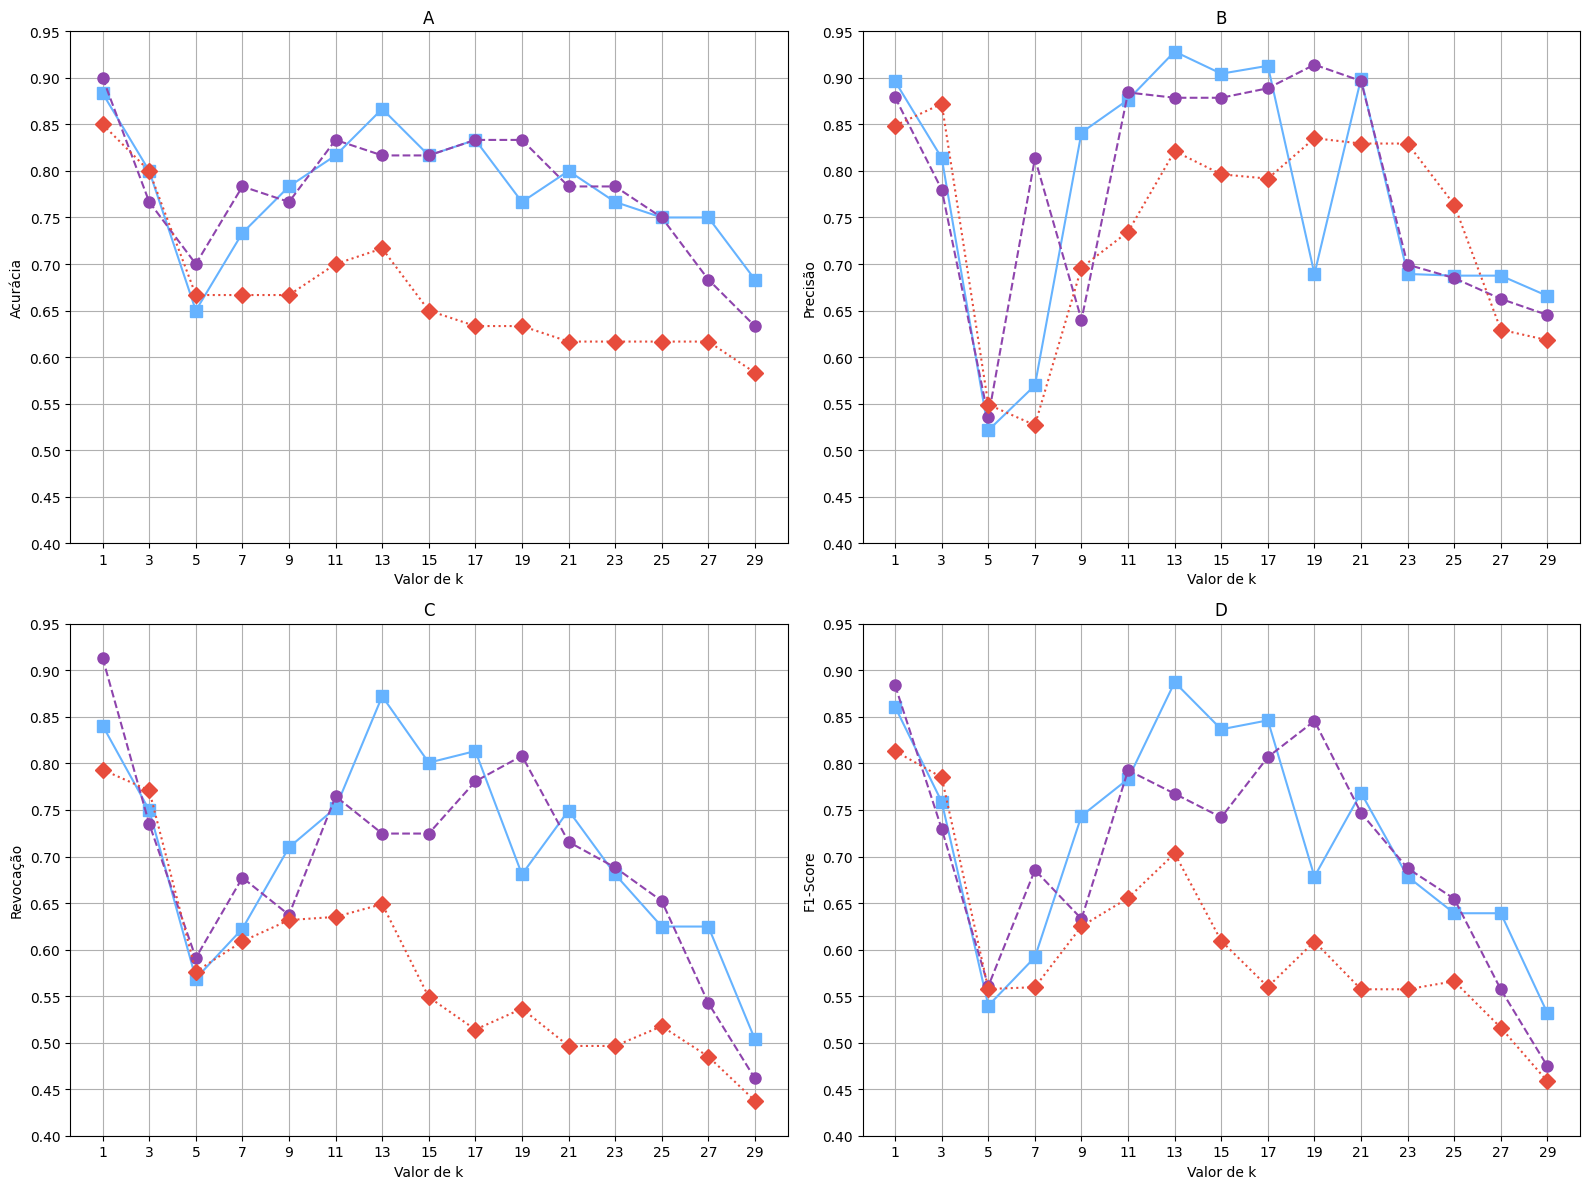

In [ ]:
import matplotlib.pyplot as plt

# Gráficos separados para cada métrica
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_labels = ['Acurácia', 'Precisão', 'Revocação', 'F1-Score']

# Criar lista de legendas para os três tipos de distância
legend_labels = []
colors = ['#66b3ff', '#8e44ad', '#e74c3c']  # Azul claro, roxo suave, rosa escuro
linestyles = ['-', '--', ':']
markers = ['s', 'o', 'D']  # Quadrado, bolinha, diamante
dist_metric_labels = {
    'euclidean': 'Euclidiana',
    'manhattan': 'Manhattan',
    'chebyshev': 'Chebyshev'
}

plt.figure(figsize=(16, 12))

# Itera sobre as métricas e plota gráficos individuais para cada métrica
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)  # Criar subplots (2 linhas, 2 colunas, posição i+1)
    for j, dist_metric in enumerate(['euclidean', 'manhattan', 'chebyshev']):
        subset = df_results_knn[df_results_knn['metric'] == dist_metric]  # Usar o DataFrame desbalanceado

        plt.plot(subset['k'], subset[metric],
                 color=colors[j],
                 linestyle=linestyles[j],
                 marker=markers[j],
                 markersize=8)  # Tamanho dos marcadores

    # Ajustar os títulos para 'A', 'B', 'C' e 'D' em maiúsculas
    plt.title(chr(65 + i))  # 'A', 'B', 'C', 'D' (letras maiúsculas)
    plt.xlabel('Valor de k')
    plt.ylabel(metric_labels[i])
    plt.grid(True)  # Adiciona a grid no fundo

    # Limitar o eixo x para k até 29 e exibir apenas valores ímpares
    plt.xticks(range(1, 30, 2))

    # Fixar o eixo Y entre 0 e 0.9, com intervalo de 0.05
    plt.ylim(0.4, 0.95)
    plt.yticks(np.arange(0.4, 1, 0.05))  # Intervalo de 0.05

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()


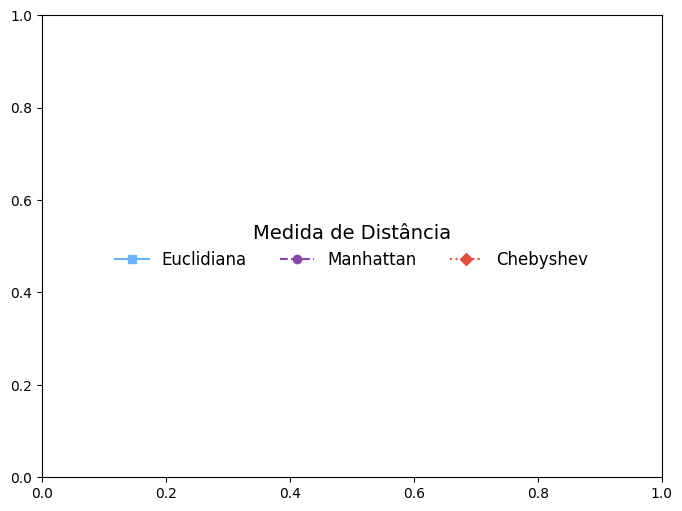

In [ ]:
# Gerar a legenda separada
plt.figure(figsize=(8, 6))  # Aumentando a área do gráfico
plt.legend(handles=[
    plt.Line2D([0], [0], color=colors[0], linestyle=linestyles[0], marker=markers[0], label=dist_metric_labels['euclidean']),
    plt.Line2D([0], [0], color=colors[1], linestyle=linestyles[1], marker=markers[1], label=dist_metric_labels['manhattan']),
    plt.Line2D([0], [0], color=colors[2], linestyle=linestyles[2], marker=markers[2], label=dist_metric_labels['chebyshev'])
], title='Medida de Distância', loc='center', ncol=3, frameon=False, fontsize=12, title_fontsize=14, bbox_to_anchor=(0.5, 0.5))  # Ajuste na posição da legenda

# Salvar a legenda como uma imagem separada
plt.savefig("legenda.png", bbox_inches='tight')

# Exibir os gráficos
plt.show()


Balanceados

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tabela para armazenar os resultados
results_knn_balanced = []

# Laço para valores de K de 1 a 25 e diferentes métricas de distância
for metric in ['euclidean', 'manhattan', 'chebyshev']:
    for k in range(1, 30, 2):  # Inclui k de 1 a 25 com passo 1
        # Treinar o modelo com o conjunto balanceado
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_balanced, y_train_balanced)  # Usar os dados balanceados

        # Previsão no conjunto de teste (mesmo conjunto desbalanceado de teste)
        y_pred = knn.predict(X_test)

        # Cálculo de métricas com average='macro' para multiclasses
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        # Armazenar resultados
        results_knn_balanced.append({
            'k': k, 'metric': metric,
            'accuracy': accuracy, 'recall': recall,
            'precision': precision, 'f1_score': f1
        })

# Converter para DataFrame e exibir a tabela completa
df_results_knn_balanced = pd.DataFrame(results_knn_balanced)

# Visualizar todos os resultados para k de 1 a 25
print("Todos os resultados para k de 1 a 25 com dados balanceados:")
print(df_results_knn_balanced)


Todos os resultados para k de 1 a 25 com dados balanceados:
     k     metric  accuracy    recall  precision  f1_score
0    1  euclidean  0.883333  0.840635   0.896199  0.860635
1    3  euclidean  0.750000  0.727619   0.738167  0.712421
2    5  euclidean  0.683333  0.697989   0.642484  0.642096
3    7  euclidean  0.700000  0.651640   0.595397  0.601941
4    9  euclidean  0.650000  0.596825   0.503349  0.524497
5   11  euclidean  0.650000  0.596825   0.499621  0.516289
6   13  euclidean  0.650000  0.596825   0.499621  0.516289
7   15  euclidean  0.650000  0.596825   0.497457  0.512508
8   17  euclidean  0.600000  0.574603   0.496364  0.487086
9   19  euclidean  0.616667  0.609511   0.526147  0.528991
10  21  euclidean  0.650000  0.662011   0.578030  0.576148
11  23  euclidean  0.666667  0.702011   0.607792  0.609135
12  25  euclidean  0.650000  0.744511   0.635873  0.621538
13  27  euclidean  0.616667  0.729696   0.621429  0.598830
14  29  euclidean  0.616667  0.724603   0.614148  0.596

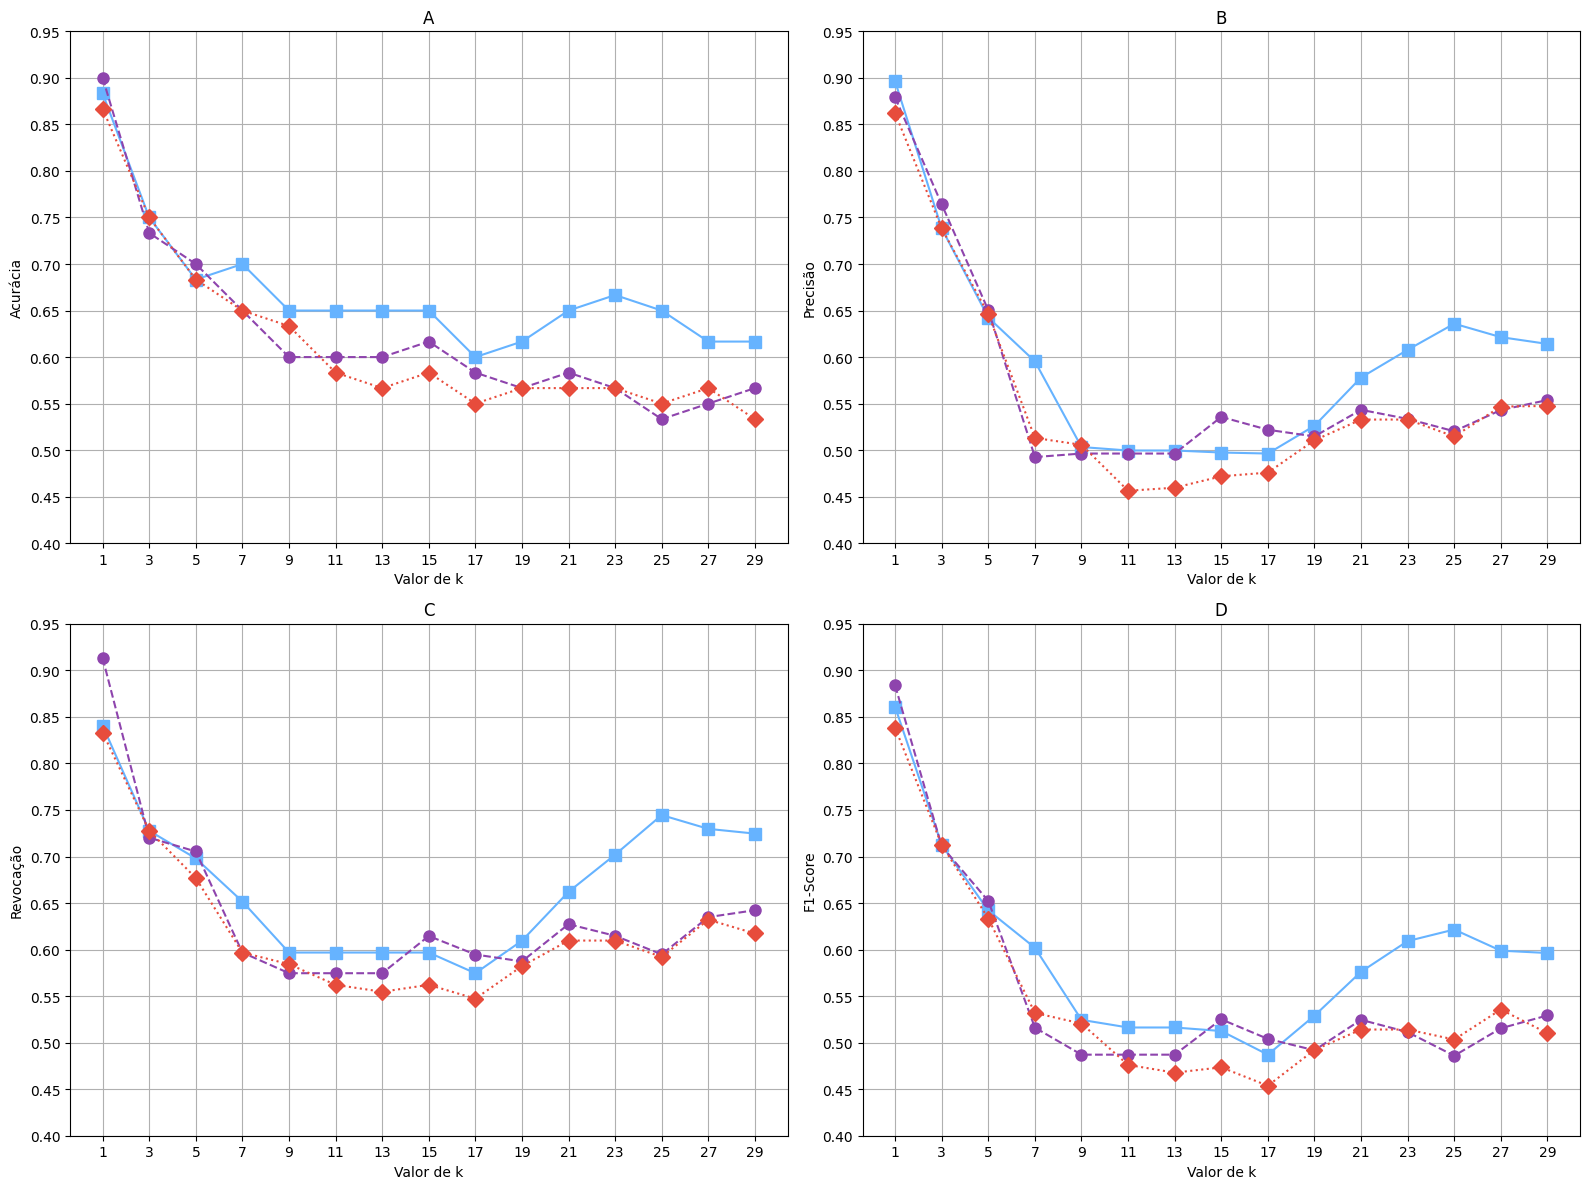

In [ ]:
import matplotlib.pyplot as plt

# Gráficos separados para cada métrica
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_labels = ['Acurácia', 'Precisão', 'Revocação', 'F1-Score']

# Criar lista de legendas para os três tipos de distância
legend_labels = []
colors = ['#66b3ff', '#8e44ad', '#e74c3c']  # Azul claro, roxo suave, rosa escuro
linestyles = ['-', '--', ':']
markers = ['s', 'o', 'D']  # Quadrado, bolinha, diamante
dist_metric_labels = {
    'euclidean': 'Euclidiana',
    'manhattan': 'Manhattan',
    'chebyshev': 'Chebyshev'
}

plt.figure(figsize=(16, 12))

# Itera sobre as métricas e plota gráficos individuais para cada métrica
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)  # Criar subplots (2 linhas, 2 colunas, posição i+1)
    for j, dist_metric in enumerate(['euclidean', 'manhattan', 'chebyshev']):
        subset = df_results_knn_balanced[df_results_knn_balanced['metric'] == dist_metric]  # Usar o DataFrame Balanceado

        plt.plot(subset['k'], subset[metric],
                 color=colors[j],
                 linestyle=linestyles[j],
                 marker=markers[j],
                 markersize=8)  # Tamanho dos marcadores

    # Ajustar os títulos para 'A', 'B', 'C' e 'D' em maiúsculas
    plt.title(chr(65 + i))  # 'A', 'B', 'C', 'D' (letras maiúsculas)
    plt.xlabel('Valor de k')
    plt.ylabel(metric_labels[i])
    plt.grid(True)  # Adiciona a grid no fundo

    # Limitar o eixo X para k até 29 e exibir apenas valores ímpares
    plt.xticks(range(1, 30, 2))

    # Fixar o eixo Y entre 0 e 0.9, com intervalo de 0.05
    plt.ylim(0.4, 0.95)
    plt.yticks(np.arange(0.4, 1, 0.05))  # Intervalo de 0.05

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()

# Exibir o gráfico
plt.show()
